# Physics Informed Neural Networks (PINNs) for 1D Heat Equation

## 1. Introduction
In this workbook, we would be training a physics informed neural network model for 1D Heat equation. In specific, we will solve:

$\frac{\partial{u}}{\partial{t}} - \nu\nabla^{2} u(x) = f(x,t)$, where $x \in [-1,1]$, and $t \in (0,1]$


We will use the concept of PINNs, where the input to the neural network is $x, t$ and the output of the network is $u(x,t)$. Loss function is evaluated by enforcing the PDE and the boundary conditions.

Physics informed neural networks is made of a dense neural network that takes in the $(x,t)$ points in the domain and learns the physics from it using PDEs such as the one just above. 

The architecture of the network looks something like this:

![](https://www.researchgate.net/profile/Zhen-Li-105/publication/335990167/figure/fig1/AS:806502679982080@1569296631121/Schematic-of-a-physics-informed-neural-network-PINN-where-the-loss-function-of-PINN.ppm)

We will use the concept of PINNs, where the input to the neural network is $(x, t)$ and the output of the network is $u(x,t)$. Loss function is evaluated by enforcing the PDE and the boundary conditions.

We will begin the workbook with few imports and creating some helper functions

## 2. Imports and helper functions

* **deepxde**    - library for solving forward and inverse problems using PINNs
* **numpy**      - library for working multi-dimensional arrays and matrices
* **matplotlib** - library for data visualization

In [1]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import time 
import matplotlib.pyplot as plt
t0 = time.time()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Helper function to plot $u(x,t)$

In [2]:
def plot(geom_time,data,name):
    plt.figure()
    plt.scatter(geom_time[:,0], geom_time[:,1],s = 20, c=np.reshape(data, (len(data),)), cmap='jet')
    plt.colorbar()
    plt.xlabel('x domain')
    plt.ylabel('time domain')
    plt.title(name)
    plt.show()

## Functions used to calcuate neural network loss

PDE: $pde(x,y) : \frac{\partial{u}}{\partial{t}} - \nu\nabla^{2} u(x) =0$, where $\nu = 0.3$ 

Boundary conditions $func(x): \sin(\pi x)e^{x}$

Deepxde provides help functions to compute first and second derivatives

_dde.grad.jacobian_ is used to compute Jacobian matrix $J: J[i][j] = \frac{dy_i}{dx_j}$, where $i,j=0,…,dim_x-1$

_dde.grad.Hessian_ is used to compute Hessian matrix $H: H[i][j] = \frac{d^2y}{dx_i dx_j}$, where $i,j=0,…,dim_x-1$

In [3]:
# define the PDE for 1D Heat equations
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    return (
        dy_t
        - dy_xx*0.3)
    

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

## 2. initialization
Define geometry and time horizons for simulation

In [4]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Define boundary conditions and initial conditions

In [5]:
bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

Create data points needed for building the model

In [6]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)

### Steps in building the model 

- Define the number of layers and neurons per layer in the neural network
- Define activation function on these layers _tanh_
- Define function for initial weights for training _Glorot uniform_
- Train the network using Adam optimizer with learning rate of 0.001

In [11]:
layer_size = [2] + [32] * 3 + [1]

activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.01, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.000259 s



## 3. Training


In [12]:
t1 = time.time()

losshistory, train_state = model.train(epochs=3000)

t2 = time.time()
print("training time:",(t2-t1))

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.08e-01, 1.80e-01, 3.07e-01]    [3.17e-01, 1.80e-01, 3.07e-01]    [1.12e+00]    
1000      [6.88e-04, 7.12e-05, 3.28e-04]    [5.12e-04, 7.12e-05, 3.28e-04]    [2.82e-01]    
2000      [3.01e-04, 2.77e-04, 4.62e-04]    [2.62e-04, 2.77e-04, 4.62e-04]    [2.88e-01]    
3000      [7.87e-05, 4.73e-05, 6.56e-05]    [7.28e-05, 4.73e-05, 6.56e-05]    [2.84e-01]    

Best model at step 3000:
  train loss: 1.92e-04
  test loss: 1.86e-04
  test metric: [2.84e-01]

'train' took 178.251175 s

training time: 178.25173807144165


## 4. Post-training Visualization

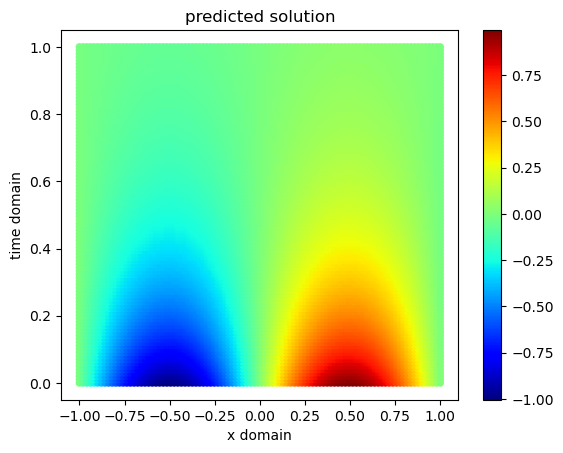

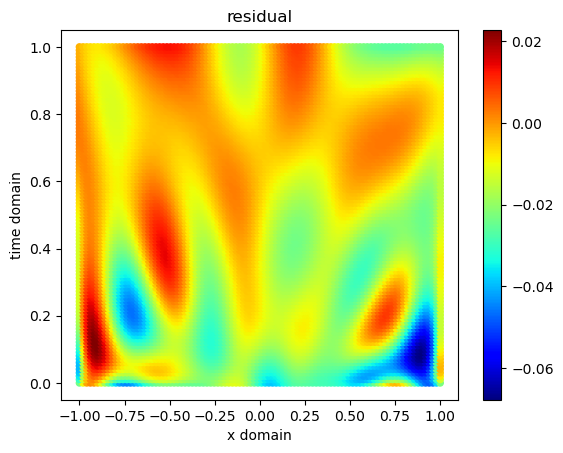

total time
162.45227193832397


In [10]:
#dde.postprocessing.plot_loss_history(losshistory)
#plt.show()


x_data = np.linspace(-1,1,num = 100)
t_data = np.linspace(0,1,num = 100)
test_x , test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain,operator=pde)



plot(test_domain,predicted_solution,"predicted solution")


plot(test_domain,residual,"residual")


print("total time")
print(t2-t0)